<h1><center>SHAEDIT</center></h1>

Welcome to SHAEDIT, the Space Hadron Accelerator Experiment Data Investigation Tool!  This is a Jupyter notebook for conveniently viewing and comparing the data collected from the measurements of double-differential secondary particle yields from intermediate-energy hadrons incident on thick-targets.  These experimental measurements were made at the NASA Space Radiation Laboratory on the Brookhaven National Laboratory campus.

There are a few steps you need to take before using this tool if this is your first session of this Jupyter notebook.  Above and on the right side of this body of text should be a small box which either says 'Trusted' or 'Not Trusted' inside it.  If this notebook is already trusted, then great!  If not, click the 'Not Trusted' box and confirm that you trust this notebook in the menu that appears.  This Jupyter notebook uses HTML and JavaScript for a few things to make using this notebook as clean an experience as possible and to allow cells, the individual units containing all of the code and UI elements below, to update by just pressing the buttons on the page (rather than having to manually run the cells), making this page usable by anyone regardless of their proficiency in any of these languages.

After the notebook is trusted, all of the following cells need to be initialized.  Either click the 'restart kernal and re-run whole notebook' button above ( &#9193; ) or run the first few cells manually by either clicking the 'Run' button above or pressing Shift+Enter a few times and then clicking the green "Initialize code" button below once it has been initialized.  This procedure will only need to be performed once for each time the Jupyter notebook is launched.


There are a few particular notes to be made about the data to prevent any confusion.
 - While all three target thicknesses were sampled for the pure Al and pure HDPE targets, only 20 g/cm&#178; and 60 g/cm&#178; targets were sampled for the hybrid/combination AlPE target, meaning no results exist for a 40 g/cm&#178; AlPE target.
 - All charged particles were measured in both the OLS and NaI detectors.  Neutrons were only measured in the OLS detectors.
 - This code does allow the user to input combinations for nonexistent datasets.  Such cases include requests for neutrons in the NaI detectors, results from a 40 g/cm&#178; AlPE target, or any secondary particle not observed or for which sufficient statistics did not exist to warrant publishing a spectrum.  Fortunately, the code will gracefully ignore requests for nonexistent data and will print a warning message above the plot for each ignored case, but please be aware that this possibility exists.
 - In the secondary particles list, the second category of neutron labeled as 'nDC' are a special exception from all of the other particles.  While all other secondaries were measured with time-of-flight techniques as produced in the upstream target, the 'nDC' set of neutrons was obtained by a pulse height spectrum deconvolution technique to characterize neutrons produced in the downstream target or elsewhere which either traveled directly to or scattered into the OLS detectors.  Due to the unknown production points of these neutrons, they cannot be normalized to solid angle.  Thus, one should avoid plotting these deconvoluted neutrons (nDC) in conjunction with any other secondary particle listed (though, the code does allow it since it could be a useful excercise for comparing just spectral shapes, not magnitudes).  However, a special exception has been added which will undo the solid angle normalization of upstream target neutrons when plotted in conjunction with these deconvoluted downstream neutrons, allowing for fair comparison of the two sets.  Note that the solid angles used for this action are just approximate since a system and neutron energy dependent solid angle was calculated for the actual upstream target results.


In [23]:
%matplotlib notebook
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import re
from IPython.display import display
import ipywidgets as w
from IPython.display import Javascript
import unicodedata as ud

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('png', 'pdf')
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

In [85]:
def find(target, myList):
    for i in range(len(myList)):
        if myList[i] == target:
            return i       

def slugify(value):
    """
    Normalizes string, converts to lowercase, removes non-alpha characters,
    and converts spaces to hyphens.
    """
    value = str(ud.normalize('NFKD', value).encode('ascii', 'ignore'))
    value = str(re.sub('[^\w\s-]', '', value).strip().lower())
    value = str(re.sub('[-\s]+', '-', value))
    return value
        
def on_click(change):
    #display(Javascript('IPython.notebook.execute_cells_below()'))  
    #display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.ncells())'))
    #display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, 6)'))
    display(Javascript('IPython.notebook.execute_cells'))

def on_click_next(change):
    display(Javascript('IPython.notebook.execute_cells([IPython.notebook.get_selected_index()+1])'))
    
def on_click_217(change):
    global checkTF
    checkTF = False
    display(Javascript('IPython.notebook.execute_cells([3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])'))

def on_click_67(change):
    display(Javascript('IPython.notebook.execute_cells([6,7])'))
    
def on_click_next_67(change):
    display(Javascript('IPython.notebook.execute_cells([IPython.notebook.get_selected_index()+1,6,7])'))
    
def on_click_add_combos(change):
    global combos, all_combos, update_print_str, currently_updating_fig_dims, refresh_options, refresh_opts
    currently_updating_fig_dims = False # this allows addition of new items to automatically rescale fig height
    combos = update_combo_variable()
    try:
        nco = len(combos)
    except:
        nco = 0
    for i in range(len(combos)):
        if combos[i] not in all_combos: all_combos.append(combos[i]) # only add unique entries
    update_print_str = "Added the selected "+str(nco)+' items/combinations.'
    if refresh_options.value == refresh_opts[0]:
        display(Javascript('IPython.notebook.execute_cells([20,21,22])')) # redraw plot
    else:
        display(Javascript('IPython.notebook.execute_cells([20])')) # print update string
    #print(print_str)

def on_click_remove_combos(change):
    global combos, all_combos, update_print_str, currently_updating_fig_dims, refresh_options, refresh_opts
    currently_updating_fig_dims = False # this allows removal of items to automatically rescale fig height
    combos = update_combo_variable()
    try:
        nco = len(combos)
    except:
        nco = 0
    for i in range(len(combos)):
        if combos[i] in all_combos:
            all_combos.remove(combos[i]) # remove entries which are already in all_combos list
    update_print_str = "Removed the selected "+str(nco)+' items/combinations.'
    if refresh_options.value == refresh_opts[0]:
        display(Javascript('IPython.notebook.execute_cells([20,21,22])')) # redraw plot
    else:
        display(Javascript('IPython.notebook.execute_cells([20])')) # print update string
    #print(print_str)

def on_click_clear_plot(change):
    global combos, all_combos, update_print_str, currently_updating_fig_dims, refresh_options, refresh_opts
    all_combos = [] # reset variable controlling what gets plotted
    currently_updating_fig_dims = False # reset to default fig size
    update_print_str = 'All items/combinations removed from plot.'
    if refresh_options.value == refresh_opts[0]:
        display(Javascript('IPython.notebook.execute_cells([20,21,22])')) # update all_combos and redraw plot
    else:
        display(Javascript('IPython.notebook.execute_cells([20])')) # print update string

def on_click_refresh_plot(change):
    global combos, all_combos, update_print_str, currently_updating_fig_dims
    if len(all_combos)==0:
        currently_updating_fig_dims = False # refreshing an empty plot always causes next render to use default figure dimensions
    else:
        currently_updating_fig_dims = True
    update_print_str = 'Plot has been updated/refreshed!'
    display(Javascript('IPython.notebook.execute_cells([20,21,22])')) # update and redraw plot
    
    
def on_click_save_plot(change):
    global fig, window_title, update_print_str
    fname = r'images\\'+window_title+'.pdf'
    fig.savefig(fname)
    update_print_str = 'Plot saved to: '+fname
    print(update_print_str) # print saved note
    
def on_click_save_plot_wbg(change):
    global fig, window_title, update_print_str, bg_color
    fname = r'images\\'+window_title+'_gbg.pdf'
    fig.savefig(fname,facecolor=bg_color)
    update_print_str = 'Plot saved to: '+fname
    print(update_print_str) # print saved note

def on_click_reset_sliders(change):
    global fig_x_in, fig_y_in, default_fig_x_in, default_fig_y_in
    fig_x_in, fig_y_in = default_fig_x_in, default_fig_y_in
    display(Javascript('IPython.notebook.execute_cells([22])')) # refresh sliders
    
def on_click_zoom_out(change):
    global zoom_mult
    zoom_mult = 8
    update_print_str = 'Zoomed out!'
    display(Javascript('IPython.notebook.execute_cells([20,21,22])')) # redraw plot
    
    
def update_combo_variable():
    global combos
    #display(Javascript('IPython.notebook.execute_cells([18])')) # update all_combos
    # get all checkbox values
    lisi = []
    for i in range(len(ion_species)):
        if ion_species[i].value: lisi.append(i)
    
    liei = []
    for i in range(len(ion_ergs)):
        if ion_ergs[i].value: liei.append(i)
            
    lftmi = []
    for i in range(len(ft_mats)):
        if ft_mats[i].value: lftmi.append(i)
            
    lftti = []
    for i in range(len(ft_thks)):
        if ft_thks[i].value: lftti.append(i)
    
    ldeti = []
    for i in range(len(dets)):
        if dets[i].value: ldeti.append(i)
    
    langi = []
    for i in range(len(angs)):
        if angs[i].value: langi.append(i)
    
    lspi = []
    for i in range(len(secs)):
        if secs[i].value: lspi.append(i)
            
    ldsi = []
    for i in range(len(dss)):
        if dss[i].value: ldsi.append(i)
    
            
    # Gather all combinations of isi, iei, ftmi, ftti, di (deti+angi), spi
    combos = []
    for isi in lisi:
        for iei in liei:
            for ftmi in lftmi:
                for ftti in lftti:
                    for deti in ldeti:
                        for ai in langi:
                            # convert to 0-11 index form
                            di_in = 6*deti + ai
                            # Fix NaI values from the earlier reordering which makes OLS/NaI comparison easier
                            if di_in==6: # user selected NaI 10
                                di=7
                            elif di_in==7: # user selected NaI 30
                                di=10
                            elif di_in==8: # user selected NaI 7.2
                                di=6
                            elif di_in==9: # user selected NaI 12.7
                                di=8
                            elif di_in==10: # user selected NaI 27.2
                                di=9
                            else:
                                di = di_in
                            
                            for spi in lspi:
                                for dsi in ldsi:
                                    combos.append([dsi,isi,iei,ftmi,ftti,spi,di])
    
    return combos
    
def on_click_run_all(change):
    display(Javascript('IPython.notebook.execute_cells_below()'))
    
# Function to plot error boxes
def makeErrorBoxes(xdata,ydata,xerror,yerror,fc='None',ec='k',alpha=1.0,lw=1):
    # Create list for all the error patches
    errorboxes = []

    # Loop over data points; create box from errors at each point
    for xc,yc,xe,ye in zip(xdata,ydata,xerror.T,yerror.T):
        rect = Rectangle((xc-xe[0],yc-ye[0]),xe.sum(),ye.sum())
        errorboxes.append(rect)

    # Create patch collection with specified colour/alpha
    pc = PatchCollection(errorboxes,facecolor=fc,alpha=alpha,edgecolor=ec,linewidth=lw)

    # Add collection to axes
    ax.add_collection(pc)    

def detector_colors(di):
    #colors_list = ['b','g','r','c','m','y'] # Python 3 old default
    #colors_list = ['#b2182b','#d6604d','#f4a582','#92c5de','#4393c3','#2166ac'] # blue to red cold
    #colors_list = ['#d73027','#f46d43','#fdae61','#abd9e9','#74add1','#4575b4'] # blue to red warm
    #colors_list = ['#762a83','#9970ab','#c2a5cf','#a6dba0','#5aae61','#1b7837'] # purple to green
    #colors_list = ['#40004b','#762a83','#9970ab','#5aae61','#1b7837','#00441b'] # purple to green darker
    #colors_list = ["#afa83a","#7f63b8","#56ae6c","#b84c7d","#ac863f","#b94d3d"] # iWantHue 1
    #colors_list = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'] # qualitative dark 1
    colors_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628'] # qualitative dark 2
    return colors_list[di]

def detector_colors_12(di):
    colors_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628','#8dd3c7','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69']
    return colors_list[di]
    
def ion_colors_5(isi):
    colors_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'] # qualitative dark 2
    return colors_list[isi]

def colors_3(i):
    colors_list = ['#e41a1c','#377eb8','#4daf4a',] # qualitative dark 2
    return colors_list[i]

def sp_colors_7(spi):
    colors_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#a65628','#f781bf'] # qualitative dark 2
    return colors_list[spi]

def gen_all_none_buttons():
    # uses ToggleButtons
    global all_none_strings
    select_all_none = w.ToggleButtons(
        options=all_none_strings,
        description='',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=all_none_strings,
    #     icons=['check'] * 5
    )
    return select_all_none

def gen_all_none_buttons_v2():
    # uses actual Buttons
    global all_none_strings
    select_all = w.Button(
        description=all_none_strings[0],
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=all_none_strings,
    #     icons=['check'] * 5
    )
    select_none = w.Button(
        description=all_none_strings[1],
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltips=all_none_strings,
    #     icons=['check'] * 5
    )
    select_all_none = [select_all,select_none]
    return select_all_none

def on_click_set_checkF(change):
    global checkTF
    checkTF = False
    display(Javascript('IPython.notebook.execute_cells([IPython.notebook.get_selected_index()+1])'))

def on_click_set_checkT(change):
    global checkTF
    checkTF = True
    display(Javascript('IPython.notebook.execute_cells([IPython.notebook.get_selected_index()+1])'))
    
data_version = 'v8'

metadata_file = 'metadata_matrix_' + data_version + '.npy'
mm_metadata = np.load(metadata_file) # data set, ion species, ion energy, target material, target thickness, secondary particle, detector, header meta data
exists_file = 'exists_matrix_' + data_version + '.npy'
mm_exists = np.load(exists_file) # data set, ion species, ion energy, target material, target thickness, secondary particle, detector

#values_file = 'values_matrix_' + data_version + '.npy'
#mm_values = np.load(values_file) # data set, ion species, ion energy, target material, target thickness, secondary particle, detector, column values, energy bins
projectile_sym_str = ['H', 'He', 'C', 'Si', 'Fe']
mm_values_names_list = []
mm_values_list = []
for i in range(5):
    mm_values_names_list.append('values_matrix_' + projectile_sym_str[i].lower() + "_" + data_version + '.npy')
    mm_values_list.append(np.load(mm_values_names_list[i]))

#print(mm_metadata[0,0,0,0,0,0,0,0])

OLS_SA_vals = [1.3343e-3,1.3381e-3,1.3376e-3,1.9072e-3,1.9066e-3,2.9180e-3]

# Initialize variables that will be called
all_combos = []
combos = []
update_print_str = ""
checkTF = False
currently_updating_fig_dims = False
zoom_mult = 1 # default zoom level to reset to

all_none_strings = ['Deselect All','Select All']

# Style options
in_publisher_mode = False
#legend_type = 'double_outside_right'
legend_type = 'combined_inside'
legend_type_list = ['combined_inside','double_outside_right']

run_all_label = w.Label(value='(This button also resets everything in this code to its default state.)')

run_all_cells_button = w.Button(
    description='Initialize code',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to load all of the code cells if not already loaded.',
    icon='play' # pencil, rotate-right, paint-brush
)

display(w.HBox([run_all_cells_button,run_all_label]))
run_all_cells_button.on_click(on_click_run_all)

<IPython.core.display.Javascript object>

A Jupyter Widget

In [86]:
ion_label = w.Label(value="Select projectile ion species.")
ion_an = gen_all_none_buttons_v2()
display(w.HBox([ion_label,ion_an[0],ion_an[1]]))
ion_an[0].on_click(on_click_set_checkF)
ion_an[1].on_click(on_click_set_checkT)

A Jupyter Widget

In [87]:
ion_anb = checkTF

projectile_sym_str = ['H', 'He', 'C', 'Si', 'Fe']
projectile_longnames_str = ['Hydrogen', 'Helium', 'Carbon', 'Silicon', 'Iron']

ion_species = [w.Checkbox(description=projectile_sym_str[i],indent=False,value=ion_anb) for i in range(len(projectile_sym_str))]

display(w.HBox((ion_species),layout=w.Layout(width='50ex')))

A Jupyter Widget

In [88]:
erg_label = w.Label(value="Select projectile ion energy(ies).")
erg_an = gen_all_none_buttons_v2()
display(w.HBox([erg_label,erg_an[0],erg_an[1]]))
erg_an[0].on_click(on_click_set_checkF)
erg_an[1].on_click(on_click_set_checkT)

A Jupyter Widget

In [89]:
erg_anb = checkTF

proj_E = ['400 MeV/n','800 MeV/n','1500 MeV/n (2500 MeV for H)']
proj_E_short = ['400 MeV/n','800 MeV/n','1500 MeV/n']

ion_ergs = [w.Checkbox(description=proj_E[i],indent=False,value=erg_anb) for i in range(len(proj_E))]

display(w.HBox((ion_ergs),layout=w.Layout(width='60ex')))

A Jupyter Widget

In [90]:
mat_label = w.Label(value="Select upstream target material(s).")
mat_an = gen_all_none_buttons_v2()
display(w.HBox([mat_label,mat_an[0],mat_an[1]]))
mat_an[0].on_click(on_click_set_checkF)
mat_an[1].on_click(on_click_set_checkT)

A Jupyter Widget

In [91]:
mat_anb = checkTF

target_mats_long = ['Aluminum','Polyethylene','Combination of Al and HDPE']
target_mats_short = ['Al','HDPE','AlPE']

ft_mats = [w.Checkbox(description=target_mats_long[i],indent=False,value=mat_anb) for i in range(len(target_mats_long))]

display(w.HBox((ft_mats),layout=w.Layout(width='60ex')))

A Jupyter Widget

In [92]:
thk_label = w.Label(value="Select upstream target thickness(es).")
thk_an = gen_all_none_buttons_v2()
display(w.HBox([thk_label,thk_an[0],thk_an[1]]))
thk_an[0].on_click(on_click_set_checkF)
thk_an[1].on_click(on_click_set_checkT)

A Jupyter Widget

In [93]:
thk_anb = checkTF

thicknesses = ['20 g/cm\u00B2','40 g/cm\u00B2','60 g/cm\u00B2']
thicknesses_pretty = [r'20 g/cm$^2$',r'40 g/cm$^2$',r'60 g/cm$^2$']

ft_thks = [w.Checkbox(description=thicknesses[i],indent=False,value=thk_anb) for i in range(len(thicknesses))]

display(w.HBox((ft_thks),layout=w.Layout(width='50ex')))

A Jupyter Widget

In [94]:
det_label = w.Label(value="Select detector type(s).")
det_an = gen_all_none_buttons_v2()
display(w.HBox([det_label,det_an[0],det_an[1]]))
det_an[0].on_click(on_click_set_checkF)
det_an[1].on_click(on_click_set_checkT)

A Jupyter Widget

In [95]:
det_anb = checkTF

detectors_short = ['OLS','NaI']
detectors_long = ['Organic Liquid Scintillator','Sodium Iodide']

dets = [w.Checkbox(description=detectors_long[i],indent=False,value=det_anb) for i in range(len(detectors_short))]

display(w.HBox((dets),layout=w.Layout(width='55ex')))

A Jupyter Widget

In [96]:
ang_label = w.Label(value="Select detector angle(s), detnoted as OLS/NaI.")
ang_an = gen_all_none_buttons_v2()
display(w.HBox([ang_label,ang_an[0],ang_an[1]]))
ang_an[0].on_click(on_click_set_checkF)
ang_an[1].on_click(on_click_set_checkT)

A Jupyter Widget

In [97]:
ang_anb = checkTF

#det_angles_raw = [['10\u00B0','30\u00B0','45\u00B0','60\u00B0','80\u00B0','135\u00B0'], ['7.2\u00B0','10\u00B0','12.7\u00B0','28.2\u00B0','30\u00B0','32.7\u00B0']]
# adjusted to make OLS/NaI 10/30 comparison easier
det_angles_raw = [['10\u00B0','30\u00B0','45\u00B0','60\u00B0','80\u00B0','135\u00B0'], ['10\u00B0','30\u00B0','7.2\u00B0','12.7\u00B0','28.2\u00B0','32.7\u00B0']]
# maintains correct order since di will get fixed before this is called
det_angles_12 = ['OLS 10\u00B0','OLS 30\u00B0','OLS 45\u00B0','OLS 60\u00B0','OLS 80\u00B0','OLS 135\u00B0','NaI 7.2\u00B0','NaI 10\u00B0','NaI 12.7\u00B0','NaI 28.2\u00B0','NaI 30\u00B0','NaI 32.7\u00B0']
det_angs = []
for i in range(6):
    det_angs.append(det_angles_raw[0][i]+' OLS / '+det_angles_raw[1][i]+' NaI')

angs = [w.Checkbox(description=det_angs[i],indent=False,value=ang_anb) for i in range(len(det_angs))]

display(w.HBox((angs),layout=w.Layout(width='130ex')))

A Jupyter Widget

In [98]:
sec_label = w.Label(value="Select secondary particle(s).")
sec_an = gen_all_none_buttons_v2()
display(w.HBox([sec_label,sec_an[0],sec_an[1]]))
sec_an[0].on_click(on_click_set_checkF)
sec_an[1].on_click(on_click_set_checkT)

A Jupyter Widget

In [99]:
sec_anb = checkTF

#particles_med = ['N (\u00B9n)','NDC (\u00B9n)','P (\u00B9H)','D (\u00B2H)','T (\u00B3H)','S (\u00B3He)','A (\u2074He)']
particles_med = ['n (\u00B9n)','nDC (\u00B9n)','p (\u00B9H)','d (\u00B2H)','t (\u00B3H)','s (\u00B3He)','\u03B1 (\u2074He)']
# only to be used in plots
particles_pretty = [r'$^1$n',r'deconvoluted $^1$n',r'$^1$p',r'$^2$d',r'$^3$t',r'$^3$He',r'$^4 \alpha$']


part_A = [1, 1, 1, 2, 3, 3, 4]

secs = [w.Checkbox(description=particles_med[i],indent=False,value=sec_anb) for i in range(len(particles_med))]

display(w.HBox((secs),layout=w.Layout(width='80ex')))

A Jupyter Widget

In [100]:
ds_label = w.Label(value="Select dataset(s) to display.")
ds_an = gen_all_none_buttons_v2()
display(w.HBox([ds_label,ds_an[0],ds_an[1]]))
ds_an[0].on_click(on_click_set_checkF)
ds_an[1].on_click(on_click_set_checkT)

A Jupyter Widget

<IPython.core.display.Javascript object>

In [106]:
ds_anb = checkTF

data_set_names = ['Experiment','MCNP simulated','PHITS simulated']
dsn_short = ['Exp.','MCNP','PHITS']

dss = [w.Checkbox(description=data_set_names[i],indent=False,value=ds_anb) for i in range(len(data_set_names))]

display(w.HBox((dss),layout=w.Layout(width='60ex')))

A Jupyter Widget

In [102]:
# Determine what to do next                                

hundred_times_label = w.Label(value="Select which axis, if any, across which plot should be separated by factors of 100 or 10.")

axis_scale_opts = ['None','Projectile','Energy','Material','Thickness','Secondary','Detector/Angle']
axis_scale_opts_tt = ['Do not scale anything','Projectile species','Projectile energy','Upstream target material','Upstream target thickness','Secondary particle','Detector and angle']

hundred_times_axis = w.ToggleButtons(
    options=axis_scale_opts,
    description='',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=axis_scale_opts_tt,
#    layout=w.Layout(width='120ex')
#     icons=['check'] * 5
)

mult_pow_opts = ['100','10']
mult_pow_opts_tts = ['lines of selected axis separated by powers of 100','lines of selected axis separated by powers of 10']
mult_pow_options = w.ToggleButtons(
    options=mult_pow_opts,
    description='',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=mult_pow_opts_tts,
#    layout=w.Layout(width='120ex')
#     icons=['check'] * 5
)

display(w.HBox([hundred_times_label,mult_pow_options]))
display(hundred_times_axis)

legend_opts_label = w.Label(value="Select legend placement.")

legend_opts = ['Inside plot','Outside plot']
legend_opts_tts = ['Places legend in "best" location inside plot area','Places legend just outside of and to the right of the plot area']
legend_placement = w.ToggleButtons(
    options=legend_opts,
    description='',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=legend_opts_tts,
#    layout=w.Layout(width='120ex')
#     icons=['check'] * 5
)

display(w.HBox([legend_opts_label,legend_placement]))


refresh_opts_label = w.Label(value="Automatically refresh plot when adding/removing/clearing?")
refresh_opts = ['Yes','No']
refresh_opts_tts = ['Add/Remove/Clear options automatically update/redraw plot','Refresh plot button must be clicked after Add/Remove/Clear to update/redraw plot']
refresh_options = w.ToggleButtons(
    options=refresh_opts,
    description='',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=refresh_opts_tts,
#    layout=w.Layout(width='120ex')
#     icons=['check'] * 5
)
display(w.HBox([refresh_opts_label,refresh_options]))

add_to_plot_button = w.Button(
    description='Add to plot',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to add selected options to current plot.',
    icon='plus' # pencil, rotate-right
)

remove_to_plot_button = w.Button(
    description='Remove from plot',
    disabled=False,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to remove selected options from current plot.',
    icon='minus' # pencil, rotate-right
)

clear_plot_button = w.Button(
    description='Clear plot',
    disabled=False,
    button_style='danger', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to remove all data from and completely reset current plot.',
    icon='remove' # pencil, rotate-right
)

reset_checkboxes_button = w.Button(
    description='Reset checkboxes',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to deselect all above checkboxes.',
    icon='exclamation' # pencil, rotate-right
)

make_plot_button = w.Button(
    description='Refresh plot',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to redraw the plot below with updated options from above.',
    icon='refresh' # pencil, rotate-right, paint-brush
)



#pre_plot_options.observe(on_click_next, 'value')

display(w.HBox(([add_to_plot_button,remove_to_plot_button,clear_plot_button,reset_checkboxes_button,make_plot_button])))

add_to_plot_button.on_click(on_click_add_combos)
remove_to_plot_button.on_click(on_click_remove_combos)
clear_plot_button.on_click(on_click_clear_plot)
reset_checkboxes_button.on_click(on_click_217)
make_plot_button.on_click(on_click_refresh_plot)




A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [112]:
print(update_print_str)

Plot has been updated/refreshed!


<IPython.core.display.Javascript object>


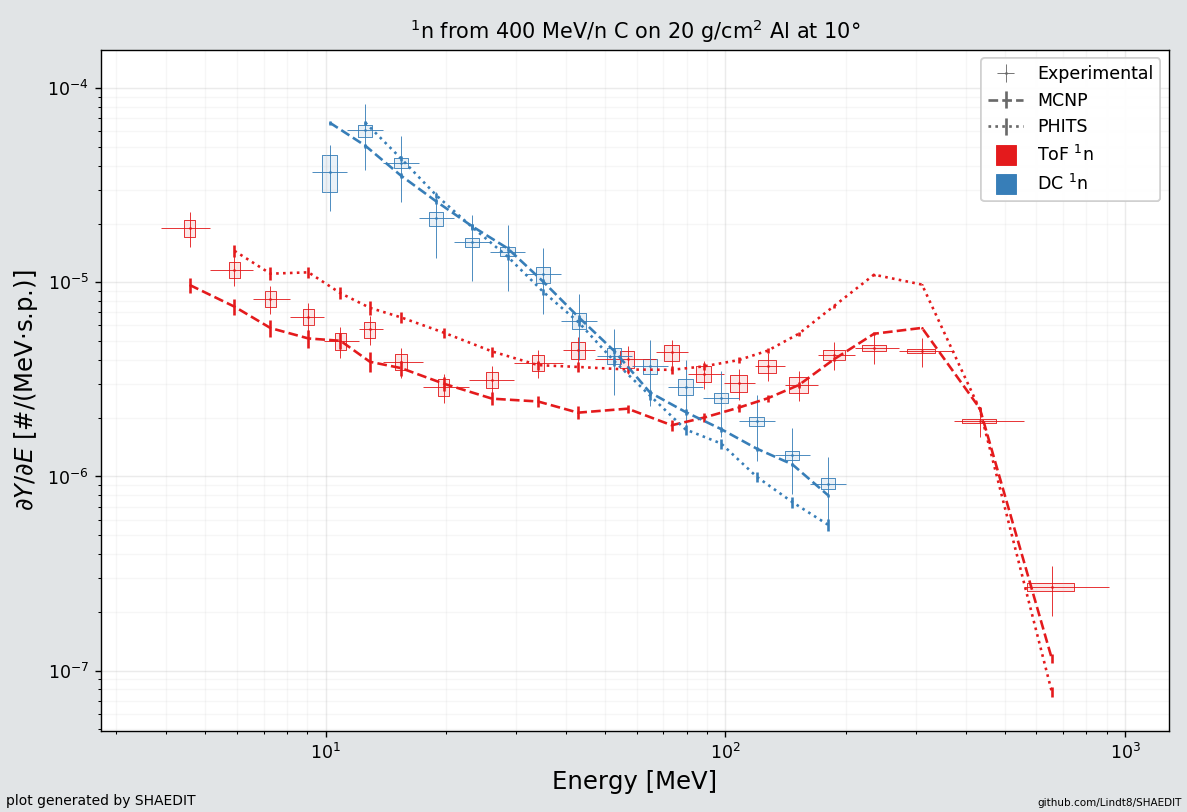

In [113]:
#print(update_print_str)
#print(all_combos)

# Generate plot
fst = 16
fs = 14
abs_min_yield = 10**(-10)
y_min = 1.000 # later used to set y-axis minimum
y_max = 0.0001 # later used to set y-axis maximum
x_min = 100 # later used to set x-axis minimum
x_max = 10 # later used to set x-axis maximum
mult_factor = 1 # default

# determine which axes are being examined
axis_names = [dsn_short,projectile_sym_str,proj_E_short,target_mats_short,thicknesses_pretty,particles_pretty,det_angles_12]
axis_names_unc = [dsn_short,projectile_sym_str,proj_E_short,target_mats_short,thicknesses,particles_med,det_angles_12]
compared_axes = [[],[],[],[],[],[],[]]
multi_value_axes = [0,0,0,0,0,0,0]
multi_value_axes_dims = [0,0,0,0,0,0,0]
multi_value_axes_bools = [0,0,0,0,0,0,0]
N_iter_each_axis = [0,0,0,0,0,0,0]
axes_dims = np.shape(mm_exists)
title_str = ""
for i in range(len(axes_dims)):
    # for each axis dimension - dsi,isi,iei,ftmi,ftti,spi,di
    # compile all unique instances
    for j in range(len(all_combos)):
        if all_combos[j][i] not in compared_axes[i]:
            compared_axes[i].append(all_combos[j][i])
    multi_value_axes[i] = len(compared_axes[i]) - 1
    multi_value_axes_dims[i] = len(compared_axes[i])
    N_iter_each_axis[i] = int(bool(len(compared_axes[i]) - 1))
    multi_value_axes_bools[i] = int(bool(len(compared_axes[i]) - 1))


# determine if only looking at nDC and n
if len(compared_axes[5])==2 and sum(compared_axes[5])==1:
    looking_at_nDC_and_n_only = True
else:
    looking_at_nDC_and_n_only = False
# determine if only looking at neutrons
neutrons_only = True
for i in range(len(all_combos)):
    if all_combos[i][5] > 1:
        neutrons_only = False
        break
    
# determine number of legend entries  
N_leg_entries = np.prod(multi_value_axes_dims[1:])
        
# Format title string according to unique axes compared
proj_strs_it = 0
targ_strs_it = 0
spi_strs_it = 0
det_strs_it = 0
title_str_parts = ['','','','','','']
for i in range(1,len(multi_value_axes)): # skip data set index since it has dedicated legend
    if not multi_value_axes[i]:
        # add to title string
        if i==1 or i==2: proj_strs_it += 1
        if i==3 or i==4: targ_strs_it += 1
        if i==5: spi_strs_it += 1
        if i==6: det_strs_it += 1
        
        title_str_parts[i-1] = axis_names[i][compared_axes[i][0]]
        
# Assemble fancy title from parts: SP from PROJ on TARG at DET
title_str = ""
if spi_strs_it>0:
    title_str += title_str_parts[4]
    if (targ_strs_it+spi_strs_it)>0:
        title_str += " from "
    elif det_strs_it>0:
        title_str += " at "
        
if proj_strs_it>0:
    if len(title_str_parts[1]) != 0:
        title_str += title_str_parts[1] + " "
    if len(title_str_parts[0]) != 0:
        title_str += title_str_parts[0] + " "
    if (len(title_str_parts[1]) != 0 or len(title_str_parts[0]) != 0) and not (len(title_str_parts[1]) != 0 and len(title_str_parts[0]) != 0):
        title_str += "projectiles "
    if targ_strs_it>0:
        title_str += "on "
    if det_strs_it>0 and targ_strs_it==0:
        title_str += "at "
        
if targ_strs_it>0:
    if len(title_str_parts[3]) != 0:
        title_str += title_str_parts[3] + " "
    if len(title_str_parts[2]) != 0:
        title_str += title_str_parts[2] + " "
    if (len(title_str_parts[3]) != 0 or len(title_str_parts[2]) != 0) and not (len(title_str_parts[3]) != 0 and len(title_str_parts[2]) != 0):
        title_str += 'targets '
    if det_strs_it>0:
        title_str += "at "

if det_strs_it>0:
    title_str += title_str_parts[5]

if looking_at_nDC_and_n_only:
    title_str = axis_names[5][0] + ' from ' + title_str
    
# fix title for hydrogen cases
if (' '+axis_names[1][0]+' ') in title_str and axis_names[2][2] in title_str:
    title_str = title_str.replace('MeV/n','MeV')
    title_str = title_str.replace('1500','2500')
elif (' '+axis_names[1][0]+' ') in title_str in title_str:
    title_str = title_str.replace('MeV/n','MeV')
    
if neutrons_only:
    title_str = title_str.replace(' OLS','') # no need to mention detector if only looking at neutrons
    
# grab legend setting
legend_type = legend_type_list[find(legend_placement.value,legend_opts)]
    
# grab multiplication factor info
multset = find(hundred_times_axis.value,axis_scale_opts)
multaxis = [0,0,0,0,0,0,0]
multaxis_i = 0
npows = 0
if multset == 0:
    base_mult_factor = 1 
    scale_plots = False
else:
    npows = len(compared_axes[multset])
    if npows > 1:
        base_mult_factor = int(mult_pow_options.value)
        exponent_multiplier = int(np.log10(base_mult_factor))
        multaxis[multset] = 1
        multaxis_i = multset
        scale_plots = True
    else:
        # user attempted to scale axis with only 1 selected value
        base_mult_factor = 1 
        scale_plots = False    


# Print warning messages above plot
for i in range(len(all_combos)):
    dsi,isi,iei,ftmi,ftti,spi,di = all_combos[i]
    if not mm_exists[dsi,isi,iei,ftmi,ftti,spi,di]: 
        warning_str = 'Nonexistent dataset ignored: ' 
        warning_str += axis_names_unc[0][dsi]+" "+axis_names_unc[5][spi]+" from "+axis_names_unc[2][iei]+" "+axis_names_unc[1][isi]+" on "
        warning_str += axis_names_unc[4][ftti]+" "+axis_names_unc[3][ftmi]+" at "+axis_names_unc[6][di]
        if isi==0:
            warning_str = warning_str.replace('MeV/n','MeV')
            if iei==2:
                warning_str = warning_str.replace('1500','2500')
        print(warning_str)
        continue # skip if it doesn't exist in set
        
        
fig = plt.figure()
bg_color = '#E1E4E6'
fig.patch.set_facecolor(bg_color)
fig.patch.set_alpha(1.0)
l_corner_logo_text = 'plot generated by SHAEDIT'
l_corner_logo_fs = 8
r_corner_logo_text = 'github.com/Lindt8/SHAEDIT'
r_corner_logo_fs = 6
ax = plt.subplot(111)
if not in_publisher_mode:
    fig.text(0.005,0.005,l_corner_logo_text,fontsize=l_corner_logo_fs,horizontalalignment='left',verticalalignment='bottom')
    fig.text(0.995,0.005,r_corner_logo_text,fontsize=r_corner_logo_fs,horizontalalignment='right',verticalalignment='bottom')
# Axis labels
plt.title(title_str)
#plt.xlabel("Energy [MeV]",fontsize=fs)
#plt.ylabel(r"Yield [#/(MeV$\cdot$sr$\cdot$s.p.)]",fontsize=fs)
x_label_str = "Energy [MeV/n]"
y_label_str = r"$\partial^2Y$/$\partial E\partial\Omega$ [#/(MeV/n$\cdot$sr$\cdot$s.p.)]"
#y_label_str = r"Yield [#/(MeV/n$\cdot$sr$\cdot$s.p.)]"
exp_leg,  = plt.errorbar(np.NaN, np.NaN,xerr=0,yerr=0,marker=".",c='dimgrey',markersize=2,linestyle="",elinewidth=0.5,markeredgewidth=0.5,capsize=0), # , label=r'Experimental (ToF)') 
MCNP_leg, = plt.errorbar(np.NaN, np.NaN,yerr=0, color='dimgrey', marker=",",markersize=3,linestyle="--"), #, label=r'Simulated (MCNP)')
PHITS_leg, = plt.errorbar(np.NaN, np.NaN,yerr=0, color='dimgrey', marker=",",markersize=3,linestyle=":"), #, label=r'Simulated (PHITS)')
legs_for_ds_all = [exp_leg, MCNP_leg, PHITS_leg]
leg_ds_strings_all = [r'Experimental',r'MCNP', r'PHITS']
legs_for_ds = []
leg_ds_strings = []
for i in compared_axes[0]:
    legs_for_ds.append(legs_for_ds_all[i])
    leg_ds_strings.append(leg_ds_strings_all[i])
    
select_color = 'k' # default
ci = 0 # color index
sp_Aprod = 1 # multiply all secondaries' A together to see if MeV/n is warranted in x/y labels
NDC_test_spi_prod = 1 # if product of all spi values is 1, only deconvoluted neutrons are present

#print(all_combos)
    
for i in range(len(all_combos)):
    dsi,isi,iei,ftmi,ftti,spi,di = all_combos[i]
    if scale_plots:
        # determine how much this plot needs to be scaled by
        mai = [dsi,isi,iei,ftmi,ftti,spi,di][multaxis_i]
        scfi = find(mai,compared_axes[multaxis_i])
        scale_power = (len(compared_axes[multaxis_i])-scfi-1)
        mult_factor = base_mult_factor**scale_power
        scale_add_to_leg_str = r" $\times10^{{{0}}}$".format(str(int(exponent_multiplier*scale_power)))
    
    # make legend string
    legstr = ""
    for j in range(1,len(multi_value_axes)):
        if multi_value_axes[j]: # [dsi,isi,iei,ftmi,ftti,spi,di]
            axis_info = [axis_names[0][dsi],axis_names[1][isi],axis_names[2][iei],axis_names[3][ftmi],axis_names[4][ftti],axis_names[5][spi],axis_names[6][di]]
            legstr += axis_info[j] + " "
    if scale_plots: legstr += scale_add_to_leg_str
    if isi==0: 
        legstr = legstr.replace('MeV/n','MeV')
        if iei == 2:
            legstr = legstr.replace('1500','2500')
    if looking_at_nDC_and_n_only:
        if spi==0:
            new_parname = 'ToF ' + axis_names[5][spi]
            legstr = legstr.replace(axis_names[5][spi],new_parname)
        if spi==1:
            new_parname = 'DC ' + axis_names[5][0]
            legstr = legstr.replace(axis_names[5][spi],new_parname)
    if spi<=1: # neutrons
        legstr = legstr.replace(' OLS','') # mentioning OLS for neutrons is redundant
    if dsi != 0: legstr = ""  
    
    # select color
    if dsi==0: # only update color choice when changing experimental data sets
        if np.sum(multi_value_axes_bools[1:]) > 1:
            # cycle through set of 12 colors used for detectors
            select_color = detector_colors_12(ci%12)
            ci += 1
        elif multi_value_axes_bools[1]:
            select_color = ion_colors_5(isi)
        elif multi_value_axes_bools[2]:
            select_color = colors_3(iei)
        elif multi_value_axes_bools[3]:
            select_color = colors_3(ftmi)
        elif multi_value_axes_bools[4]:
            select_color = colors_3(ftti)
        elif multi_value_axes_bools[5]:
            select_color = sp_colors_7(spi)
        elif multi_value_axes_bools[6]:
            select_color = detector_colors_12(di)
    
    if not mm_exists[dsi,isi,iei,ftmi,ftti,spi,di]: continue # skip if it doesn't exist in set
    short_combo = [all_combos[i][0]] + all_combos[i][2:]
    sp_Aprod = sp_Aprod*part_A[spi]
    NDC_test_spi_prod = NDC_test_spi_prod*spi
    
    #legstr = mm_metadata[dsi,isi,iei,ftmi,ftti,spi,di,1] # pull file ID
    #legstr = legstr[:-3]
    #if dsi != 0:
    #    legstr = legstr[0] + legstr[4:]
    #legstr = legstr.replace("_"," ")
    #legstr = legstr.replace("deg",r"$^\circ$")
    #if dsi != 0 and ([0,isi,iei,ftmi,ftti,spi,di] in all_combos):
    #    legstr = ""
    
    mm_values = mm_values_list[isi]
    
    # Enforce minimum yield value
    trash_y_vals = mm_values[dsi,iei,ftmi,ftti,spi,di,3,:] < abs_min_yield
    mm_values[dsi,iei,ftmi,ftti,spi,di,3,:][trash_y_vals] = 0
        
    nzi = np.nonzero(mm_values[dsi,iei,ftmi,ftti,spi,di,3,:])
    xdata = mm_values[dsi,iei,ftmi,ftti,spi,di,1,:][nzi]/part_A[spi]
    xbinw = [mm_values[dsi,iei,ftmi,ftti,spi,di,1,:][nzi]-mm_values[dsi,iei,ftmi,ftti,spi,di,0,:][nzi] , mm_values[dsi,iei,ftmi,ftti,spi,di,2,:][nzi]-mm_values[dsi,iei,ftmi,ftti,spi,di,1,:][nzi]]
    ydata = mm_values[dsi,iei,ftmi,ftti,spi,di,3,:][nzi]
    yerr_stat = mm_values[dsi,iei,ftmi,ftti,spi,di,4,:][nzi]
    yerr_sys = mm_values[dsi,iei,ftmi,ftti,spi,di,5,:][nzi]
    xerr = mm_values[dsi,iei,ftmi,ftti,spi,di,6,:][nzi]/part_A[spi]    
    if spi==1: 
        xerr = 0.2*(mm_values[dsi,iei,ftmi,ftti,spi,di,2,:][nzi]-mm_values[dsi,iei,ftmi,ftti,spi,di,0,:][nzi])
    
    if looking_at_nDC_and_n_only and spi==0:
        # undo solid angle normalization for neutrons
        ydata = ydata*OLS_SA_vals[di]
        yerr_stat = yerr_stat*OLS_SA_vals[di]
        yerr_sys = yerr_sys*OLS_SA_vals[di]
    
    ydata = ydata*mult_factor
    yerr_stat = yerr_stat*mult_factor
    yerr_sys = yerr_sys*mult_factor
    
    
    if len(ydata) != 0:
        if min(ydata)<y_min: y_min = min(ydata)
        if max(ydata)>y_max: y_max = max(ydata)
        if min(mm_values[dsi,iei,ftmi,ftti,spi,di,0,:][nzi]/part_A[spi])<x_min: x_min = min(mm_values[dsi,iei,ftmi,ftti,spi,di,0,:][nzi])/part_A[spi]
        if max(mm_values[dsi,iei,ftmi,ftti,spi,di,2,:][nzi]/part_A[spi])>x_max: x_max = max(mm_values[dsi,iei,ftmi,ftti,spi,di,2,:][nzi])/part_A[spi]
    
    # Generate plots
    if dsi == 0: # experimental results
        # x error bar (bin width)
        xerrbar = xbinw
        # x error box (energy resolution
        xerrbox = xerr
        xerrbox = np.array([xerrbox, xerrbox])
        # y error bar (systematic uncertainty)
        yerrbar = [yerr_sys, yerr_sys]
        yerrbar[0][(ydata-yerrbar[0])<=0]=0 # get rid of negative error bars
        yerrbar[1][(ydata)<=0]=0 # get rid of errorbars on negative points
        # y error box (statistical uncertainty)
        yerrbox = np.array([yerr_stat, yerr_stat])
        
        p = ax.errorbar(xdata,ydata,xerr=xerrbar,yerr=yerrbar,marker=".",c=select_color,markersize=2,linestyle="",elinewidth=0.5,markeredgewidth=0.5,capsize=0,label=legstr)
        nx_color = select_color #p[0].get_color()
        makeErrorBoxes(xdata,ydata,xerrbox,yerrbox,fc='None',ec=nx_color,alpha=1.0,lw=0.5)
        makeErrorBoxes(xdata,ydata,xerrbox,yerrbox,fc=nx_color,ec='None',alpha=0.1,lw=0.5)
                
    elif dsi == 1: # MCNP results
        ebp = plt.errorbar(xdata,ydata,yerr=yerr_stat,c=select_color,marker=",",markersize=3,linestyle="--",label=legstr) #,label='Simulated (MCNP)')
    
    elif dsi == 2: # PHITS results
        ebp = plt.errorbar(xdata,ydata,yerr=yerr_stat,c=select_color,marker=",",markersize=3,linestyle=":",label=legstr) #,label='Simulated (PHITS)')
        
if sp_Aprod==1:
    x_label_str = x_label_str.replace('MeV/n','MeV')
    y_label_str = y_label_str.replace('MeV/n','MeV')

if NDC_test_spi_prod==1 or looking_at_nDC_and_n_only:
    y_label_str = y_label_str.replace(r'$\cdot$sr','')
    y_label_str = y_label_str.replace(r"$\partial^2Y$/$\partial E\partial\Omega$",r"$\partial Y$/$\partial E$")
    
plt.xlabel(x_label_str,fontsize=fs)
plt.ylabel(y_label_str,fontsize=fs)


# hangle figure/legend positioning/sizing
# First, figure size
default_fig_x_in = 9.5
in_per_pow = 0.5
if scale_plots:
    default_fig_y_in = 6.5 + in_per_pow*npows
else:
    default_fig_y_in = 6.5

# first, try getting widget widths from below; otherwise, use defaults
if currently_updating_fig_dims:
    fig_x_in = adjust_w_slider.value
    fig_y_in = adjust_h_slider.value
else:
    fig_x_in = default_fig_x_in
    fig_y_in = default_fig_y_in

fig.set_size_inches(fig_x_in,fig_y_in)


# Add legend(s)
if legend_type == 'double_outside_right':
    # Add primary legend
    leg1_anchor = (1.0, 0.75) # varied items 
    handles_l1, labels_l1 = ax.get_legend_handles_labels()
    # remove the errorbars
    if len(handles_l1)>0:
        handles_l1 = [h[0] for h in handles_l1]
        legend1 = ax.legend(handles_l1, labels_l1,loc='upper left',bbox_to_anchor=leg1_anchor,ncol=1)
        ax.add_artist(legend1)
        # Change marker in legend
        for l in legend1.get_lines():
            #l.set_alpha(1)
            l._legmarker.set_marker('s')
            l._legmarker.set_markersize(12)
        leg1_exists = True
    else:
        leg1_exists = False
    
    # Put a legend below current axis (only if comparing more than one data set)
    if len(compared_axes[0])>1:
        # data set legend at bottom of plot
        #leg2_anchor = (0.5, 0.05) # data sets
        #legend2 = ax.legend(legs_for_ds,leg_ds_strings,loc='upper center', bbox_to_anchor=leg2_anchor, bbox_transform=plt.gcf().transFigure, ncol=3)
        
        leg2_anchor = (1.0, 0.75) # data sets
        legend2 = ax.legend(legs_for_ds,leg_ds_strings,loc='lower left', bbox_to_anchor=leg2_anchor, ncol=1)
        leg2_exists = True
    else:
        leg2_exists = False
    
elif legend_type == 'combined_inside':
    handles_l1, labels_l1 = ax.get_legend_handles_labels()
    # remove the errorbars
    if len(handles_l1)>0 or len(compared_axes[0])>1: # There will be a legend
        if len(handles_l1)>0 and len(compared_axes[0])>1: # combined legend
            handles_l1 = [h[0] for h in handles_l1]
            handles_combined = legs_for_ds + handles_l1
            labels_combined = leg_ds_strings + labels_l1
        elif len(compared_axes[0])>1:
            handles_combined = legs_for_ds
            labels_combined = leg_ds_strings
        elif len(handles_l1)>0:
            handles_l1 = [h[0] for h in handles_l1]
            handles_combined = handles_l1
            labels_combined = labels_l1
        
        legend1 = ax.legend(handles_combined, labels_combined,loc='best',ncol=1)
        ax.add_artist(legend1)
        
        # Change marker in legend for colored items
        for l in legend1.get_lines():
            #l.set_alpha(1)
            l._legmarker.set_marker('s')
            l._legmarker.set_markersize(12)

        
        # want leg. variables to be false since this legend won't affect plot area width
        leg1_exists = False
        leg2_exists = False
    else:
        leg1_exists = False
        leg2_exists = False
    
    
    
    
    
if len(all_combos) != 0: # stuff that will error out code on first initialization
    if leg1_exists or leg2_exists: fig.canvas.draw()  # draw to force legend dimensions to be calculated
    if leg1_exists:
        f1 = legend1.get_frame()
        l1_w0_px, l1_h0_px = f1.get_width(), f1.get_height()
    if leg2_exists:
        f2 = legend2.get_frame()
        l2_w0_px, l2_h0_px = f2.get_width(), f2.get_height()
    if leg1_exists and leg2_exists:
        l_w0_in, l_h0_in = max(l1_w0_px,l2_w0_px)/fig.dpi, max(l1_h0_px,l2_h0_px)/fig.dpi # max legend dimensions in inches
    elif leg1_exists:
        l_w0_in, l_h0_in = l1_w0_px/fig.dpi, l1_h0_px/fig.dpi # max legend dimensions in inches
    elif leg2_exists:
        l_w0_in, l_h0_in = l2_w0_px/fig.dpi, l2_h0_px/fig.dpi # max legend dimensions in inches
    else:
        l_w0_in, l_h0_in = 0 , 0 # no legends
    
    # Determine relative dimensions of plot
    x0bar = 0.8075 # inches, horizontal space needed for ylabel
    if len(compared_axes[0])>1:
        #y0bar = 0.9500 # inches, vertical space needed for xlabel + bot legend, with data set legend below x axis
        y0bar = 0.6500 # inches, vertical space needed for xlabel + bot legend
    else:
        y0bar = 0.6500 # inches, vertical space needed for xlabel alone
    t0bar = 0.4000 # inches, vertical space needed for title
    del_l_in = 0.15 # inches, extra horizontal padding right of legend

    x0 = x0bar/fig_x_in
    y0 = y0bar/fig_y_in
    h0 = 1 - (y0bar+t0bar)/fig_y_in
    w0 = 1 - x0 - (l_w0_in/fig_x_in) - (del_l_in/fig_x_in)
    
    # Set size and location of the plot on the canvas
    box = ax.get_position()
    # all vals in [0,1]: left, bottom, width, height
    ax.set_position([x0, y0, w0, h0])


# Put a legend below current axis
#ax.legend(leg_handles1[:(len(det_angle_i_list))],leg_labels1[:(len(det_angle_i_list))],loc='upper center', bbox_to_anchor=leg1_anchor, ncol=3,handletextpad=0.1)
#ax.add_artist(legend2)

window_title = slugify(title_str) # "comparison_fig"
fig.canvas.set_window_title(window_title)

# color of box immediately surrounding plot area
#ax.spines['bottom'].set_color('0.5')
#ax.spines['top'].set_color('0.5')
#ax.spines['right'].set_color('0.5')
#ax.spines['left'].set_color('0.5')

plt.xscale('log')
plt.yscale('log')
plt.grid(b=True, which='major', linestyle='-', alpha=0.25)
plt.grid(b=True, which='minor', linestyle='-', alpha=0.10)
#plt.xlim([5,2000])
x_log_buffer = 0.15*zoom_mult
y_log_buffer = 0.2*zoom_mult

# ensure at least minimum number of decades are present on a plot by increasing padding if necessary
min_x_decs = 2
min_y_decs = 2
if (np.log10(x_max)-np.log10(x_min)+2*x_log_buffer) < min_x_decs:
    x_log_buffer = 0.5*(min_x_decs - (np.log10(x_max)-np.log10(x_min)))
if (np.log10(y_max)-np.log10(y_min)+2*y_log_buffer) < min_y_decs:
    y_log_buffer = 0.5*(min_y_decs - (np.log10(y_max)-np.log10(y_min)))

if len(all_combos) != 0: # more stuff that will error out code on first initialization
    plt.xlim([10**(np.log10(x_min)-x_log_buffer),10**(np.log10(x_max)+x_log_buffer)])
    plt.ylim([10**(np.log10(y_min)-y_log_buffer),10**(np.log10(y_max)+y_log_buffer)])  
#print(y_min,y_max)
#plt.ylim([10**np.floor(np.log10(y_min)),10**np.ceil(np.log10(y_max))])  

plt.show() 




In [114]:
save_plot_button = w.Button(
    description='Save plot (PDF)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save plot as PDF in local images/ folder (white background)',
    icon='save' # pencil, rotate-right
)

save_plot_button_wbg = w.Button(
    description='(with gray BG)',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Save plot as PDF in local images/ folder (gray background)',
    icon='save' # pencil, rotate-right
)

save_plot_extra_label = w.Label(value='(Default save uses all white background; the second option keeps gray around the plot.)')

adjust_label = w.Label(value="Adjust figure dimensions via sliders or text boxes (all units in inches, minimum dimension = 1\", maximum dimension = 10\").")

adjust_w_slider = w.FloatSlider(
    description='width (in.)',
    min=1,
    max=10,
    value = fig_x_in,
)
adjust_w_text = w.FloatText(step=0.1)

adjust_h_slider = w.FloatSlider(
    description='height (in.)',
    min=1,
    max=10,
    value = fig_y_in,
)

reset_sliders_button = w.Button(
    description='Reset sliders',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to reset sliders to default values.',
    icon='exclamation' # pencil, rotate-right, paint-brush
)
adjust_h_text = w.FloatText(step=0.1)

refresh_plot_button2 = w.Button(
    description='Refresh plot',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to redraw the plot with updated dimensions.',
    icon='refresh' # pencil, rotate-right, paint-brush
)

zoom_mult = 1 # reset zoom value
zoom_out_label = w.Label(value='Zooming in can be freely done within the interactive plot.  This button zooms out the default view.')
zoom_out_button = w.Button(
    description='Zoom out',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='While you can freely zoom in to any rectangle on the interactive plot, there is no way to zoom out from the starting view.  This solves that issue.',
    icon='search-minus' # pencil, rotate-right
)

display(w.HBox([zoom_out_label,zoom_out_button]))
zoom_out_button.on_click(on_click_zoom_out)

display(adjust_label)
display(w.HBox([adjust_w_slider,adjust_h_slider,reset_sliders_button,refresh_plot_button2]))
display(w.HBox([adjust_w_text,adjust_h_text]))
w_link = w.jslink((adjust_w_slider, 'value'), (adjust_w_text, 'value'))
h_link = w.jslink((adjust_h_slider, 'value'), (adjust_h_text, 'value'))
reset_sliders_button.on_click(on_click_reset_sliders)
refresh_plot_button2.on_click(on_click_refresh_plot)

display(w.HBox([save_plot_button,save_plot_button_wbg,save_plot_extra_label]))
save_plot_button.on_click(on_click_save_plot)
save_plot_button_wbg.on_click(on_click_save_plot_wbg)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

Note: 

If you wish to save a plot as a PDF with the above buttons and are running this Jupyter notebook locally (meaning your URL looks something like ``localhost:8888/notebooks/SHAEDIT.ipynb``), you must create a folder titled ``images`` within the main directory which holds this notebook and the data files it relies on; plots will be saved in that ``images`` folder with descriptive filenames resembling the plot title.   

If you are viewing this online, the save buttons are not guaranteed to work.  If viewing this on Binder, the save buttons will generate the PDFs in the repository window (the page on which you clicked the ``SHAEDIT.ipynb`` link to arrive here), but you must download them locally yourself before you leave the site because they will be erased once your Binder session is ended.  

If you wish to save the image as a PNG (regardless of where you are viewing the data from), you must click the little power button ( &#9211; ) in the top right of the figure, right click the image, and click "Save image as..." to save it to a local folder. 

<center>SHAEDIT was written by Hunter Ratliff at the University of Tennessee, Knoxville, Department of Nuclear Engineering. (2018)</center>